In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import sklearn as sk

In [2]:
# Prepare data folder for archiving
import os

# Ensure that we have a folder for the model archives
MODELS_FOLDER = "model_archive"
os.makedirs(MODELS_FOLDER, exist_ok=True)

# Find current model iteration by looking at the folders in the current directory
CURRENT_MODEL_ITERATION = len([name for name in os.listdir(os.path.join('.', 'model_archive'))])

# Create folder for current model iteration
ITERATION_FOLDER = os.path.join(MODELS_FOLDER, "model_simple_{}".format(CURRENT_MODEL_ITERATION))
os.mkdir(ITERATION_FOLDER)

In [3]:
# Import data
df = pd.read_csv('../data/combined_dataframe.csv')

# Drop irrelevant columns
df = df.drop(['START_TIME', 'END_TIME'], axis=1)

# Convert bools to ints in every column that has bools
bool_cols = [col for col in df.columns if df[col].dtype == 'bool']
df[bool_cols] = df[bool_cols].astype(int)

df.head(5)

,TAG_LECTURE,TAG_MEETING,TAG_WORKOUT,TAG_VOLLEYBAL,TAG_PARTY,TAG_TUTOR,TAG_HAIRCUT,TAG_SELFSTUDY,TAG_PROMOCIE,TAG_COOKING,...,TAG_CALLING,TAG_HIGHSCHOOLFRIENDS,DURATION,DAY_OF_WEEK,HOUR_OF_DAY,EVENTS_PER_DAY,HRT_AVG,HRT_MED,HRT_10,HRT_90
0,1,0,0,0,0,0,0,0,0,0,...,0,0,240,1,8,4,83.152174,80.0,70.9,99.2
1,1,1,0,0,0,0,0,0,0,0,...,0,0,240,2,8,6,91.588496,90.0,76.0,113.0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,120,2,13,6,85.271930,83.0,73.3,99.7
3,1,1,0,0,0,0,0,0,0,0,...,0,0,240,3,13,5,80.308696,78.0,70.0,95.0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,120,4,8,5,81.615385,79.0,71.3,95.4


In [4]:
np.random.seed(42)

target_headers = ["HRT_AVG", "HRT_MED", "HRT_10", "HRT_90"]
X = df.drop(target_headers, axis=1)
y = df[target_headers]
feature_headers = X.columns

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

In [5]:
MODELS = []
MSE = []
RMSE = []
MAE = []
R2 = []
MAPE = []

def register_errors(model_title, mse, rmse, mae, r2, mape):
    MODELS.append(model_title)
    MSE.append(mse)
    RMSE.append(rmse)
    MAE.append(mae)
    R2.append(r2)
    MAPE.append(mape)

In [6]:
def plot_scatter_single(title, test, pred, mse, rmse, mae, r2, mape):
    register_errors(title, mse, rmse, mae, r2, mape)
    
    colors = ['blue', 'orange', 'green', 'red']

    for i in range(4):
        plt.scatter(test, pred)

    x = np.linspace(*plt.xlim())
    y = x
    plt.plot(x, y, color="black")

    # Model predictions lines
    from sklearn.linear_model import LinearRegression
    for i in range(4):
        reg = LinearRegression().fit(test, pred)
        plt.plot(x, reg.predict(x.reshape(-1, 1)), color=colors[i], linestyle="dashed", alpha=0.5)

    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)

    plt.annotate("MSE: {:.3f}".format(mse), (0.7, 0.25), xycoords='axes fraction')
    plt.annotate("RMSE: {:.3f}".format(rmse), (0.7, 0.20), xycoords='axes fraction')
    plt.annotate("MAE: {:.3f}".format(mae), (0.7, 0.15), xycoords='axes fraction')
    plt.annotate("R2: {:.3f}".format(r2), (0.7, 0.10), xycoords='axes fraction')
    plt.annotate("MAPE: {:.2f}%".format(mape * 100), (0.7, 0.05), xycoords='axes fraction')

    plt.xlim(40, 160)

    plt.savefig(os.path.join(ITERATION_FOLDER, "{}_{}".format(title, CURRENT_MODEL_ITERATION)))

    plt.show()
    
def plot_scatter_np(title, test, pred, mse, rmse, mae, r2, mape):
    register_errors(title, mse, rmse, mae, r2, mape)
    
    colors = ['blue', 'orange', 'green', 'red']
    
    test = test.transpose()
    pred = pred.transpose()

    for i in range(4):
        plt.scatter(test[i], pred[i])

    x = np.linspace(*plt.xlim())
    y = x
    plt.plot(x, y, color="black")

    # Model predictions lines
    from sklearn.linear_model import LinearRegression
    for i in range(4):
        reg = LinearRegression().fit(test[i].reshape(-1, 1), pred[i].reshape(-1, 1))
        plt.plot(x, reg.predict(x.reshape(-1, 1)), color=colors[i], linestyle="dashed", alpha=0.5)

    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)

    plt.annotate("MSE: {:.3f}".format(mse), (0.7, 0.25), xycoords='axes fraction')
    plt.annotate("RMSE: {:.3f}".format(rmse), (0.7, 0.20), xycoords='axes fraction')
    plt.annotate("MAE: {:.3f}".format(mae), (0.7, 0.15), xycoords='axes fraction')
    plt.annotate("R2: {:.3f}".format(r2), (0.7, 0.10), xycoords='axes fraction')
    plt.annotate("MAPE: {:.2f}%".format(mape * 100), (0.7, 0.05), xycoords='axes fraction')

    plt.savefig(os.path.join(ITERATION_FOLDER, "{}".format(title)))

    plt.show()
    
def plot_scatter(title, test, pred, mse, rmse, mae, r2, mape):
    register_errors(title, mse, rmse, mae, r2, mape)
    
    colors = ['blue', 'orange', 'green', 'red']

    test = test.to_numpy()

    for i in range(4):
        plt.scatter(test[:, i], pred[:, i])

    x = np.linspace(*plt.xlim())
    y = x
    plt.plot(x, y, color="black")

    # Model predictions lines
    from sklearn.linear_model import LinearRegression
    for i in range(4):
        reg = LinearRegression().fit(test[:, i].reshape(-1, 1), pred[:, i].reshape(-1, 1))
        plt.plot(x, reg.predict(x.reshape(-1, 1)), color=colors[i], linestyle="dashed", alpha=0.5)

    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)

    plt.annotate("MSE: {:.3f}".format(mse), (0.7, 0.25), xycoords='axes fraction')
    plt.annotate("RMSE: {:.3f}".format(rmse), (0.7, 0.20), xycoords='axes fraction')
    plt.annotate("MAE: {:.3f}".format(mae), (0.7, 0.15), xycoords='axes fraction')
    plt.annotate("R2: {:.3f}".format(r2), (0.7, 0.10), xycoords='axes fraction')
    plt.annotate("MAPE: {:.2f}%".format(mape * 100), (0.7, 0.05), xycoords='axes fraction')

    plt.xlim(40, 160)
    
    plt.savefig(os.path.join(ITERATION_FOLDER, "{}".format(title)))

    plt.show()

## Dummy Regressor (ZeroR Mean)

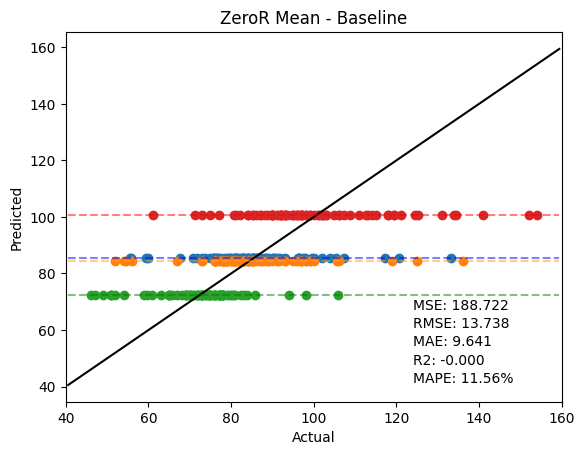

In [7]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# create a dummy regressor
dummy_reg = DummyRegressor(strategy='mean')
# fit it on the training set
dummy_reg.fit(X_train, y_train)
# make predictions on the test set
y_pred = dummy_reg.predict(X_test)

# calculate root mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = sk.metrics.r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

plot_scatter("ZeroR Mean - Baseline", y_test, y_pred, mse, rmse, mae, r2, mape)

## Linear Regression

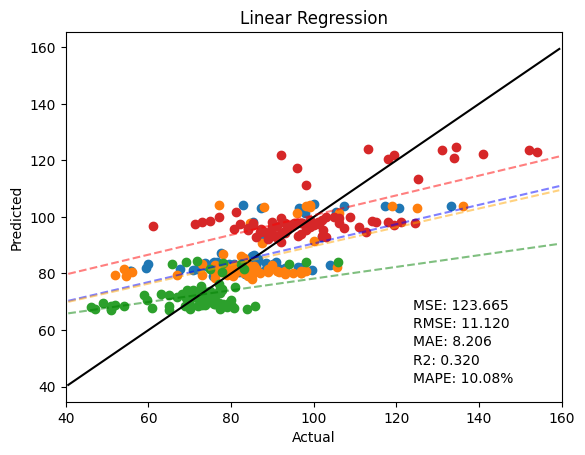

In [8]:
from sklearn.linear_model import LinearRegression

# create a linear regression model
lin_reg = LinearRegression()
# fit on the training data
lin_reg.fit(X_train, y_train)
# make predictions on the test set
y_pred = lin_reg.predict(X_test)

# calculate root mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = sk.metrics.r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

plot_scatter("Linear Regression", y_test, y_pred, mse, rmse, mae, r2, mape)

## Decision Tree

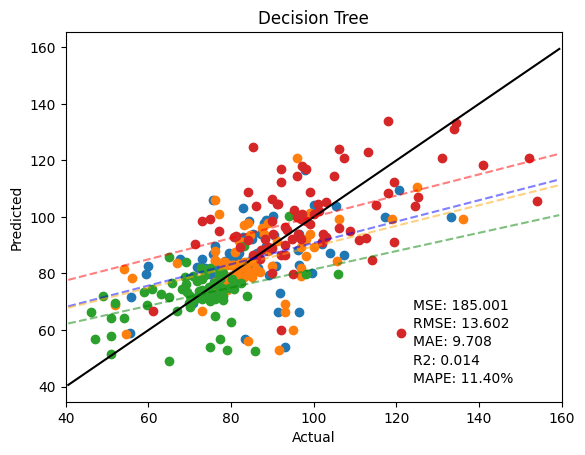

In [13]:
from sklearn import tree

# Create a decision tree regressor
tree_reg = tree.DecisionTreeRegressor()
# Fit it to the training set
tree_reg.fit(X_train, y_train)
# Make predictions on the test set
y_pred = tree_reg.predict(X_test)

# calculate root mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = sk.metrics.r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

plot_scatter("Decision Tree", y_test, y_pred, mse, rmse, mae, r2, mape)

## Random Forest

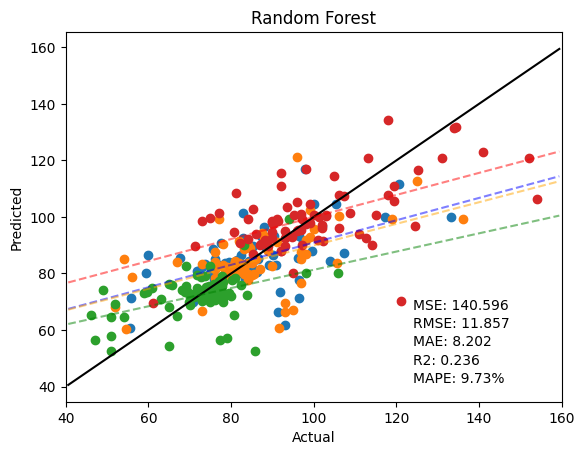

In [9]:
from sklearn.ensemble import RandomForestRegressor

# create a random forest regressor
rf_reg = RandomForestRegressor()
# fit on the training data
rf_reg.fit(X_train, y_train)
# make predictions on the test set
y_pred = rf_reg.predict(X_test)

# calculate root mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = sk.metrics.r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

plot_scatter("Random Forest", y_test, y_pred, mse, rmse, mae, r2, mape)

## Gradient Boosting

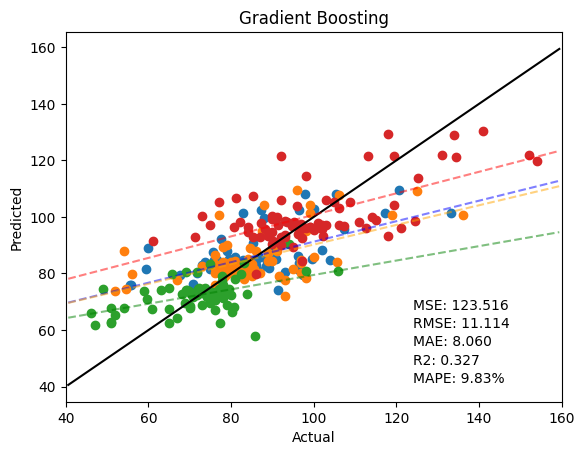

In [10]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

# create a gradient boosting regressor
gb_reg = GradientBoostingRegressor()
# Multi output regressor
mor = MultiOutputRegressor(gb_reg)
# fit on the training data
mor.fit(X_train.to_numpy(), y_train.to_numpy())
# make predictions on the test set
y_pred = mor.predict(X_test.to_numpy())

# calculate root mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = sk.metrics.r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

plot_scatter("Gradient Boosting", y_test, y_pred, mse, rmse, mae, r2, mape)

## Support Vector Machine

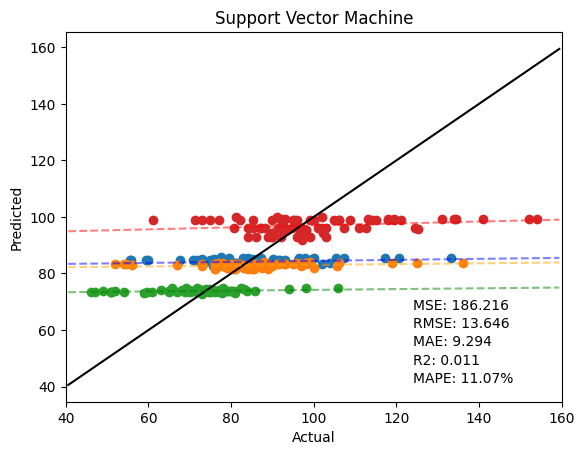

In [11]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

# create a support vector regressor
sv_reg = SVR(epsilon=0.2)
# Multi output regressor
mor = MultiOutputRegressor(sv_reg)
# fit on the training data
mor.fit(X_train.to_numpy(), y_train.to_numpy())
# make predictions on the test set
y_pred = mor.predict(X_test.to_numpy())

# calculate root mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = sk.metrics.r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

plot_scatter("Support Vector Machine", y_test, y_pred, mse, rmse, mae, r2, mape)

## Saving to index

In [12]:
# Make sure index file exists
INDEX_FILE_PATH = os.path.join(MODELS_FOLDER, "index.csv")
if not os.path.exists(INDEX_FILE_PATH):
    with open(INDEX_FILE_PATH, 'w') as f:
        f.write("INDEX, MODEL_NAME, LAYERS, RUN_EPOCHS, BATCH_SIZE, LEARNING_RATE, MSE, RMSE, MAE, R2, MAPE\n")

def get_csv_entry(model, epochs, folds, batch_size, lr, mse, rmse, mae, r2, mape):
    return "{},{},{},{},{},{},{},{},{},{},{},{}\n".format(CURRENT_MODEL_ITERATION, model, "n/a", epochs, folds, batch_size, lr, mse, rmse, mae, r2, mape)
    
# Append to index file
with open(INDEX_FILE_PATH, 'a') as f:    
    for i in range(len(MODELS)):
        f.write(get_csv_entry(MODELS[i], -1, -1, -1, -1, MSE[i], RMSE[i], MAE[i], R2[i], MAPE[i]))